In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [51]:
# %load neuralnet_backprop.py
import numpy as np

def softmax(a):
    c = np.max(a)
    exp_a = np.exp(a - c)
    y = exp_a / np.sum(exp_a)
    return y

def softmax_batch(A):
    return np.apply_along_axis(arr=A, axis=1, func1d=softmax)

def cross_entroy_error(y_pred, y):
    """분류용 손실함수"""
    delta = 1e-7 # 아주 작은 값.     
    return -np.sum(y * np.log(y_pred + delta))

def cross_entropy_error_batch(y_pred, y):
    batch_size = len(y)
    cse = cross_entroy_error(y_pred, y) / batch_size
    return cse


class ReLu:
    def __init__(self):
        self.mask = None
        
    def forward(self, x):
        self.mask = x > 0
        return np.where(self.mask, x, 0)
    
    def backward(self, dout):
        return np.where(self.mask, 1, 0)


class Sigmoid:
    def __init__(self):
        self.out = None
        
    def forward(self, x):
        self.out = 1 / (1 + np.exp(-x))
        return self.out
    
    def backward(self, dout):
        dx = dout * self.out * (1 - self.out)
        return dx


class Affine:
    def __init__(self, 입력수, 출력수):
        self.W = np.random.randn(입력수, 출력수) * 0.5
        self.b = np.random.randn(출력수) * 0.5
        self.X = None
        self.dW = None
        self.db = None
        
    def forward(self, X):
        self.X = X
        z = np.dot(X, self.W) + self.b
        return z
    
    def backward(self, dout):
        dX = np.dot(dout, self.W.T)
        self.dW = np.dot(self.X.T, dout)
        self.db = np.sum(dout, axis=0)
        return dX


class SoftmaxCrossEntropy:
    def __init__(self):
        self.Y = None
        self.Y_pred = None
        
    def forward(self, X, Y):
        self.Y = Y
        self.Y_pred = softmax_batch(X)
        loss = cross_entropy_error_batch(self.Y_pred, self.Y)
        return loss
    
    def backward(self, dout=1):
        batch_size = len(self.Y)
        dX = (self.Y_pred - self.Y) / batch_size
        return dX


class FeedForwardNet:
    def __init__(self):
        self.layers = []
        
    def add(self, layer):
        self.layers.append(layer)
        
    def predict(self, X):
        layer_output = X
        for layer in self.layers[:-1]:
            layer_output = layer.forward(layer_output)            
        return layer_output
    
    def compute_loss(self, X, Y):
        Y_pred = self.predict(X)
        loss = self.layers[-1].forward(Y_pred, Y)
        return loss
    
    def fit(self, X, y, batch_size, iterator, learning_rate):
        loss_history = []
        for i in range(iterator):
            # 1. 미니배치
            샘플수 = len(X)
            배치색인 = np.random.choice(샘플수, batch_size)
            X_batch = X[배치색인]
            y_batch = y[배치색인]
            # 2. 기울기 산출
            #  1) 순전파
            self.compute_loss(X_batch, y_batch)
            #  2) 역전파
            dout = 1
            for layer in reversed(self.layers):
                dout = layer.backward(dout)
            # 3. 갱신
            for layer in self.layers:
                if isinstance(layer, Affine):
                    layer.W -= layer.dW * learning_rate
                    layer.b -= layer.db * learning_rate
            
            # 손실 확인
            loss = self.compute_loss(X_batch, y_batch)
            loss_history.append(loss)
            print('[학습 {}] Loss: {}'.format(i+1, loss))
        
        return loss_history

In [52]:
# Affine Transformation
# 의미: XOR문제를 선형모델로 풀기 어려워쓴데, 이래 저래해서 데이터 변환을 거쳐서 선형모델로 풀 수 있도록 할 수 있기 때문에 중요하게 됨.

# 계단함수는 미분이 안되는 문제가 있음.
# tanh은 계단함수와 비슷하나 미분이 가능해서 도입이 됨.
# Relu는 0보다 큰 구간에서는 미분이 가능함. 0이하부터는 모두 0임. sigmoid보다 연산도 간단해서 편리함. 어느 구간이 0보다 큰지만 기억하면 됨.

# 요새는 cross entropy를 무조건 설정하고 있음...

In [53]:
# class Affine:
#     def __init__(self, input_count, output_count):
#         self.W = np.random.randn(input_count, output_count)
#         self.b = np.random.randn(output_count)
#         self.X = None
#         self.dW = None
#         self.db = None
    
#     def forward(self, X):
#         self.X = X
#         z = np.dot(X, self.W) + self.b
#         return z
    
#     def backward(self, dout):
#         dX = np.dot(dout, self.W.T)
#         self.dW = np.dot(self.X.T, dout)
#         self.db = np.sum(dout, axis=0)
#         return dX

In [54]:
# class SoftmaxCrossEntropy:
#     def __init__(self):
#         # 분류의 문제는 one-hot encoding하니까 대문자로 표시하기.
#         self.Y = None
#         self.Y_pred = None
        
#     def forward(self, X, Y):
#         self.Y = Y
#         self.Y_pred = softmax_batch(X) # X는 바로 직전의 affine 값을 처리하는 거라고 해석하기.
#         loss = cross_entropy_error_batch(self.Y_pred, self.Y)
#         return loss
    
#     def backward(self, dout=1):
#         batch_size = len(self.Y)
#         dX = (self.Y_pred - self.Y) / batch_size
#         return dX

In [55]:
# class FeedForwardNet:
#     def __init__(self):
#         self.layers = []
        
#     def add(self, layer):
#         self.layers.append(layer)
        
#     # 순전파
#     def predict(self, X):
#         layer_output = X
#         # -1을 하는 건 SoftmaxCrossEntropy forward에서 X, Y 모두 필요한데 모양이 안 맞아서?
#         for layer in self.layers[:-1]:
#             layer_output = layer.forward(layer_output)
#         return layer_output
    
#     def compute_loss(self, X, Y):
#         Y_pred = self.predict(X)
#         loss = self.layers[-1].forward(Y_pred, Y)
#         return loss
        
#     # iterator: 학습횟수
#     def fit(self, X, Y, batch_size, iterator, learning_rate = 0.01):
#         loss_history = []
#         for i in range(iterator):
#             # 1. 미니배치
#             sample_out = len(X)
#             batch_index = np.random.choice(sample_out, batch_size)
#             X_batch = X[batch_index]
#             y_batch = Y[batch_index]
            
#             # 2. 기울기 산출
#             #  1) 순전파
#             self.compute_loss(X_batch, y_batch)
            
#             #  2) 역전파
#             dout = 1
#             for layer in reversed(self.layers):
#                 dout = layer.backward(dout)
                
#             # 3. 갱신
#             for layer in self.layers:
#                 if isinstance(layer, Affine):
#                     layer.W -= layer.dW * learning_rate
#                     layer.b -= layer.db * learning_rate
                    
#             # 손실 확인
#             loss = self.compute_loss(X_batch, y_batch)
#             loss_history.append(loss)
#             print('[learning {}] loss: {}'.format(i+1, loss))
            
#         return loss_history     

In [56]:
# def softmax_batch(A):
#     return np.apply_along_axis(arr=A, axis=1, func1d=softmax)

# def cross_entroy_error(y_pred, y):
#     """분류용 손실함수"""
#     delta = 1e-7 # 아주 작은 값.     
#     return -np.sum(y * np.log(y_pred + delta))

# def cross_entropy_error_batch(y_pred, y):
#     batch_size = len(y)
#     cse = cross_entroy_error(y_pred, y) / batch_size
#     return cse

In [57]:
from deepy.dataset import mnist

In [58]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_mnist(flatten=True, normalize=True, one_hot_label=True)

In [59]:
model = FeedForwardNet()

In [60]:
model.add(Affine(784,50))
model.add(Sigmoid())
model.add(Affine(50,100))
model.add(Sigmoid())
model.add(Affine(100,10))
model.add(SoftmaxCrossEntropy())

In [61]:
loss_history = model.fit(X_train, Y_train, 
                         batch_size=100, iterator=600*10, 
                         learning_rate=0.01)

[학습 1] Loss: 3.903136576447789
[학습 2] Loss: 4.113261191586692
[학습 3] Loss: 4.394309208439181
[학습 4] Loss: 3.9783199863101917
[학습 5] Loss: 3.8599602721629687
[학습 6] Loss: 4.019079711785427
[학습 7] Loss: 3.9732802144388017
[학습 8] Loss: 3.9258160118620573
[학습 9] Loss: 3.263980951192896
[학습 10] Loss: 3.2158343170367685
[학습 11] Loss: 3.4811126709937703
[학습 12] Loss: 3.5161506050752145
[학습 13] Loss: 3.4997716221468407
[학습 14] Loss: 3.4551219082654527
[학습 15] Loss: 3.2408511975373266
[학습 16] Loss: 3.347871264597595
[학습 17] Loss: 3.3472215884769914
[학습 18] Loss: 3.3112919839882062
[학습 19] Loss: 3.1205177506389417
[학습 20] Loss: 3.2643926861347627
[학습 21] Loss: 3.1888824820656936
[학습 22] Loss: 2.958503459409128
[학습 23] Loss: 3.0149519147986066
[학습 24] Loss: 2.6958814919706553
[학습 25] Loss: 2.7627142482058686
[학습 26] Loss: 3.0718563409222974
[학습 27] Loss: 2.9059440411327695
[학습 28] Loss: 2.78556997419433
[학습 29] Loss: 2.8541210261060472
[학습 30] Loss: 2.722691789829256
[학습 31] Loss: 2.6974273997091

[학습 254] Loss: 2.0669001412740444
[학습 255] Loss: 2.0267989233046126
[학습 256] Loss: 2.1286117153950275
[학습 257] Loss: 2.209913986219372
[학습 258] Loss: 2.116372880958979
[학습 259] Loss: 2.2227687814453603
[학습 260] Loss: 2.1706643651305777
[학습 261] Loss: 2.037382943988333
[학습 262] Loss: 2.1503740623935483
[학습 263] Loss: 2.110007101766875
[학습 264] Loss: 2.0692764174700113
[학습 265] Loss: 2.164143574488732
[학습 266] Loss: 2.101619165495425
[학습 267] Loss: 2.2447888014463775
[학습 268] Loss: 2.0776232083479953
[학습 269] Loss: 2.1423258398457214
[학습 270] Loss: 2.171771739176204
[학습 271] Loss: 2.1413771915748434
[학습 272] Loss: 2.208459017157584
[학습 273] Loss: 2.10805243697181
[학습 274] Loss: 2.0837177744594673
[학습 275] Loss: 2.1694789257439115
[학습 276] Loss: 2.070806664689316
[학습 277] Loss: 2.2405710629281357
[학습 278] Loss: 2.108852942048075
[학습 279] Loss: 2.025602741085146
[학습 280] Loss: 2.038968400244379
[학습 281] Loss: 2.0254583582829473
[학습 282] Loss: 2.098502718497965
[학습 283] Loss: 2.075661934431

[학습 517] Loss: 1.8735860287907116
[학습 518] Loss: 1.9625537955551169
[학습 519] Loss: 1.76522582134429
[학습 520] Loss: 1.9803295391466844
[학습 521] Loss: 1.8749746782659662
[학습 522] Loss: 1.8360613011165123
[학습 523] Loss: 1.8383592147695444
[학습 524] Loss: 1.8074687109326062
[학습 525] Loss: 1.872714939676097
[학습 526] Loss: 1.8863102323182601
[학습 527] Loss: 1.9267375788234664
[학습 528] Loss: 1.7580072508906435
[학습 529] Loss: 1.8355736620187821
[학습 530] Loss: 1.852620683944191
[학습 531] Loss: 1.80887008103908
[학습 532] Loss: 1.7591418736319946
[학습 533] Loss: 1.7973859734692048
[학습 534] Loss: 1.7607901609556393
[학습 535] Loss: 1.819938646672752
[학습 536] Loss: 1.7806726089164846
[학습 537] Loss: 1.8181027742365978
[학습 538] Loss: 1.8208028045760647
[학습 539] Loss: 1.7326321981543662
[학습 540] Loss: 1.746279894988695
[학습 541] Loss: 1.870286792173641
[학습 542] Loss: 1.6924821510888877
[학습 543] Loss: 1.7956652630947603
[학습 544] Loss: 1.8273083122976477
[학습 545] Loss: 1.8740624411001203
[학습 546] Loss: 1.834208

[학습 776] Loss: 1.7058879801340194
[학습 777] Loss: 1.6992951384264432
[학습 778] Loss: 1.5928195028869316
[학습 779] Loss: 1.712714764910298
[학습 780] Loss: 1.5290126205624597
[학습 781] Loss: 1.4986600321397754
[학습 782] Loss: 1.6977665848311096
[학습 783] Loss: 1.5884556157785994
[학습 784] Loss: 1.7146342357269304
[학습 785] Loss: 1.527901807050692
[학습 786] Loss: 1.5990398424987928
[학습 787] Loss: 1.5149072036271423
[학습 788] Loss: 1.7453929031526467
[학습 789] Loss: 1.554176167698726
[학습 790] Loss: 1.6934621037451558
[학습 791] Loss: 1.5988973510369504
[학습 792] Loss: 1.6199965908706553
[학습 793] Loss: 1.6386427638776981
[학습 794] Loss: 1.5271593180021423
[학습 795] Loss: 1.5411266448024736
[학습 796] Loss: 1.501228663330561
[학습 797] Loss: 1.4672547410495078
[학습 798] Loss: 1.6839194964302506
[학습 799] Loss: 1.5430183090139156
[학습 800] Loss: 1.5970093864222008
[학습 801] Loss: 1.5759016269345683
[학습 802] Loss: 1.5985330207773911
[학습 803] Loss: 1.5890713193892143
[학습 804] Loss: 1.6703712942335556
[학습 805] Loss: 1.6

[학습 1041] Loss: 1.4977822659585711
[학습 1042] Loss: 1.497593989395055
[학습 1043] Loss: 1.4887615456837022
[학습 1044] Loss: 1.4787295863816992
[학습 1045] Loss: 1.6181250312805577
[학습 1046] Loss: 1.4286927360997856
[학습 1047] Loss: 1.3842563476268979
[학습 1048] Loss: 1.471788441983393
[학습 1049] Loss: 1.3793017908047123
[학습 1050] Loss: 1.4343978399428974
[학습 1051] Loss: 1.261116715597926
[학습 1052] Loss: 1.470933759306024
[학습 1053] Loss: 1.4415957468435503
[학습 1054] Loss: 1.4509070198421217
[학습 1055] Loss: 1.22255900189298
[학습 1056] Loss: 1.4751475000749037
[학습 1057] Loss: 1.4093946711318557
[학습 1058] Loss: 1.3088153770835889
[학습 1059] Loss: 1.5419822063345392
[학습 1060] Loss: 1.592696164011623
[학습 1061] Loss: 1.4088944217506587
[학습 1062] Loss: 1.4512815251958961
[학습 1063] Loss: 1.5736452416476356
[학습 1064] Loss: 1.4774561406403757
[학습 1065] Loss: 1.4132604502567563
[학습 1066] Loss: 1.5426040951191538
[학습 1067] Loss: 1.4280467129147993
[학습 1068] Loss: 1.2559500990912111
[학습 1069] Loss: 1.501066588

[학습 1279] Loss: 1.424288516682458
[학습 1280] Loss: 1.2296499225077664
[학습 1281] Loss: 1.45317527602403
[학습 1282] Loss: 1.2658485560488595
[학습 1283] Loss: 1.3295439577777766
[학습 1284] Loss: 1.2855960049252024
[학습 1285] Loss: 1.4308063588356357
[학습 1286] Loss: 1.4648300718491765
[학습 1287] Loss: 1.3398903225067793
[학습 1288] Loss: 1.2615095136554375
[학습 1289] Loss: 1.2367657541262442
[학습 1290] Loss: 1.455759106289321
[학습 1291] Loss: 1.3262257383104252
[학습 1292] Loss: 1.3820110494726867
[학습 1293] Loss: 1.2737786149481558
[학습 1294] Loss: 1.4535493361336511
[학습 1295] Loss: 1.16873450034186
[학습 1296] Loss: 1.2462355311266917
[학습 1297] Loss: 1.338080240461589
[학습 1298] Loss: 1.223705894770714
[학습 1299] Loss: 1.3958265715512568
[학습 1300] Loss: 1.2119648155124891
[학습 1301] Loss: 1.3449434358645413
[학습 1302] Loss: 1.5187843784123891
[학습 1303] Loss: 1.1926042395543142
[학습 1304] Loss: 1.2800643429177998
[학습 1305] Loss: 1.4091914976926188
[학습 1306] Loss: 1.5052996781841643
[학습 1307] Loss: 1.3122962484

[학습 1544] Loss: 1.1263399520804789
[학습 1545] Loss: 1.2254177432672868
[학습 1546] Loss: 1.3604649936552002
[학습 1547] Loss: 1.1804442310425234
[학습 1548] Loss: 1.30910705599158
[학습 1549] Loss: 1.3415634494549633
[학습 1550] Loss: 1.1692126964674463
[학습 1551] Loss: 1.3127530985644569
[학습 1552] Loss: 1.3678954307152942
[학습 1553] Loss: 1.1589341394779744
[학습 1554] Loss: 1.1066619611935402
[학습 1555] Loss: 1.3772490006471736
[학습 1556] Loss: 1.2543680303149611
[학습 1557] Loss: 1.289779095944346
[학습 1558] Loss: 1.2054432083778013
[학습 1559] Loss: 1.2460277486820808
[학습 1560] Loss: 1.2691951411001094
[학습 1561] Loss: 1.1345323463860517
[학습 1562] Loss: 1.256876852353309
[학습 1563] Loss: 1.353082157609677
[학습 1564] Loss: 1.235491276685197
[학습 1565] Loss: 1.2516993857423953
[학습 1566] Loss: 1.1362099495406037
[학습 1567] Loss: 1.1927199583583978
[학습 1568] Loss: 1.1902354501140497
[학습 1569] Loss: 1.2550601871678793
[학습 1570] Loss: 1.2751308128507868
[학습 1571] Loss: 1.2717955940191599
[학습 1572] Loss: 1.25048210

[학습 1809] Loss: 1.094147324064569
[학습 1810] Loss: 1.167694540362684
[학습 1811] Loss: 1.0828585390732273
[학습 1812] Loss: 1.1180195723922932
[학습 1813] Loss: 0.9998047195632885
[학습 1814] Loss: 1.2628877113647565
[학습 1815] Loss: 1.0452399997910289
[학습 1816] Loss: 1.1709737191812681
[학습 1817] Loss: 1.1022789160969995
[학습 1818] Loss: 1.16063873138914
[학습 1819] Loss: 0.9909455436288735
[학습 1820] Loss: 0.999163478207598
[학습 1821] Loss: 1.1308255390910218
[학습 1822] Loss: 1.132257363025376
[학습 1823] Loss: 1.1833654995068246
[학습 1824] Loss: 1.012329199175359
[학습 1825] Loss: 1.108261654304092
[학습 1826] Loss: 1.0886902407305175
[학습 1827] Loss: 1.285905031902783
[학습 1828] Loss: 1.0060653656197542
[학습 1829] Loss: 1.0257365130046514
[학습 1830] Loss: 1.1208098737731804
[학습 1831] Loss: 1.133360648825753
[학습 1832] Loss: 1.0962661533462421
[학습 1833] Loss: 1.1182236189494836
[학습 1834] Loss: 1.1717976823602272
[학습 1835] Loss: 1.1544712161346131
[학습 1836] Loss: 1.2220271701006695
[학습 1837] Loss: 1.087720153168

[학습 2071] Loss: 1.1545251243533192
[학습 2072] Loss: 0.9059198208458921
[학습 2073] Loss: 1.0099953587911161
[학습 2074] Loss: 0.9259627944622517
[학습 2075] Loss: 1.084119261394855
[학습 2076] Loss: 0.9941349077473605
[학습 2077] Loss: 1.1078202876253902
[학습 2078] Loss: 1.2852043052288062
[학습 2079] Loss: 0.9056668874235683
[학습 2080] Loss: 1.1090167750113569
[학습 2081] Loss: 1.1378535281208535
[학습 2082] Loss: 1.0831901955881162
[학습 2083] Loss: 1.0134931001764778
[학습 2084] Loss: 1.0874080002663025
[학습 2085] Loss: 1.204654318863637
[학습 2086] Loss: 0.9960225523044091
[학습 2087] Loss: 0.9602861640369358
[학습 2088] Loss: 1.0894180549455248
[학습 2089] Loss: 1.1223532303813912
[학습 2090] Loss: 1.126307974094402
[학습 2091] Loss: 1.160408418824933
[학습 2092] Loss: 1.0502577305598546
[학습 2093] Loss: 1.177998834257525
[학습 2094] Loss: 0.9791215101362712
[학습 2095] Loss: 1.0110805360359612
[학습 2096] Loss: 1.1211248462258154
[학습 2097] Loss: 1.0127181010664927
[학습 2098] Loss: 0.932248482124008
[학습 2099] Loss: 1.18540485

[학습 2334] Loss: 1.112895452445663
[학습 2335] Loss: 0.8709467236762555
[학습 2336] Loss: 1.0206712506948108
[학습 2337] Loss: 1.0217573138594065
[학습 2338] Loss: 1.0059673702890006
[학습 2339] Loss: 0.9035445481725537
[학습 2340] Loss: 1.0263188853547727
[학습 2341] Loss: 0.8783369875025612
[학습 2342] Loss: 0.8693989501234168
[학습 2343] Loss: 1.0926242501777028
[학습 2344] Loss: 0.9759721041287875
[학습 2345] Loss: 0.9893859210168786
[학습 2346] Loss: 1.067278609421747
[학습 2347] Loss: 1.0698288839540024
[학습 2348] Loss: 1.0610609615495326
[학습 2349] Loss: 1.0002058497419946
[학습 2350] Loss: 0.8796519470664391
[학습 2351] Loss: 0.9432211573881772
[학습 2352] Loss: 1.0377514125458214
[학습 2353] Loss: 1.0993459456271861
[학습 2354] Loss: 0.9566279861587131
[학습 2355] Loss: 1.1820274784647484
[학습 2356] Loss: 0.9057604976578375
[학습 2357] Loss: 0.859624664838977
[학습 2358] Loss: 0.9946517141115865
[학습 2359] Loss: 0.9134298854887968
[학습 2360] Loss: 1.101720197204614
[학습 2361] Loss: 1.1700973312000216
[학습 2362] Loss: 1.007161

[학습 2597] Loss: 1.0556526638064572
[학습 2598] Loss: 0.9598069800137397
[학습 2599] Loss: 0.9074664406839128
[학습 2600] Loss: 0.8688071325646917
[학습 2601] Loss: 1.0470940121172094
[학습 2602] Loss: 0.9344916700443509
[학습 2603] Loss: 0.827376050358269
[학습 2604] Loss: 0.8938531652040921
[학습 2605] Loss: 0.9079403805771031
[학습 2606] Loss: 0.9200955457816531
[학습 2607] Loss: 1.0268805392374443
[학습 2608] Loss: 1.0484683648224786
[학습 2609] Loss: 0.902467107585158
[학습 2610] Loss: 0.9480846928614055
[학습 2611] Loss: 0.8580659403636717
[학습 2612] Loss: 1.040480022054493
[학습 2613] Loss: 0.9128720106058483
[학습 2614] Loss: 0.9752787579068374
[학습 2615] Loss: 0.9760397518176053
[학습 2616] Loss: 1.147238622944329
[학습 2617] Loss: 0.9337420695314737
[학습 2618] Loss: 0.9602220534956342
[학습 2619] Loss: 0.9596420106924971
[학습 2620] Loss: 0.8168063417848286
[학습 2621] Loss: 0.9507284107510323
[학습 2622] Loss: 1.0179722609555244
[학습 2623] Loss: 0.9525828632762355
[학습 2624] Loss: 0.9033646069356319
[학습 2625] Loss: 0.857732

[학습 2862] Loss: 0.8627647608954934
[학습 2863] Loss: 0.887954392664771
[학습 2864] Loss: 0.9313434938969283
[학습 2865] Loss: 0.8973486381823786
[학습 2866] Loss: 0.9861200257442306
[학습 2867] Loss: 0.7802589822471612
[학습 2868] Loss: 0.9608906512597645
[학습 2869] Loss: 1.0260271808817296
[학습 2870] Loss: 0.8560887570506642
[학습 2871] Loss: 0.858043275264881
[학습 2872] Loss: 1.0710103802681974
[학습 2873] Loss: 0.8697567432465516
[학습 2874] Loss: 1.0103223171313844
[학습 2875] Loss: 0.8530826811306063
[학습 2876] Loss: 0.7795750941484498
[학습 2877] Loss: 0.8488039758983047
[학습 2878] Loss: 0.8346526118941938
[학습 2879] Loss: 0.9248935537442315
[학습 2880] Loss: 0.8336549919578831
[학습 2881] Loss: 0.929834887104329
[학습 2882] Loss: 0.9865697021089299
[학습 2883] Loss: 0.8310215844170799
[학습 2884] Loss: 0.8105234113751199
[학습 2885] Loss: 0.736962923338966
[학습 2886] Loss: 0.7508290972774252
[학습 2887] Loss: 0.7971322439072737
[학습 2888] Loss: 1.0033818502174139
[학습 2889] Loss: 1.0293073385148461
[학습 2890] Loss: 0.728179

[학습 3129] Loss: 0.8258856841950402
[학습 3130] Loss: 0.8933428873813014
[학습 3131] Loss: 0.8106804828543804
[학습 3132] Loss: 0.9734316496186629
[학습 3133] Loss: 0.8402385075037384
[학습 3134] Loss: 0.7700388974589433
[학습 3135] Loss: 0.7193357211610097
[학습 3136] Loss: 0.7942049327284235
[학습 3137] Loss: 0.7444604641760749
[학습 3138] Loss: 0.8767224472647059
[학습 3139] Loss: 0.8313764169587387
[학습 3140] Loss: 0.7788277702915056
[학습 3141] Loss: 0.9775970455111039
[학습 3142] Loss: 0.8565543999305548
[학습 3143] Loss: 0.820610349693418
[학습 3144] Loss: 0.7224792761970048
[학습 3145] Loss: 0.9189960675708275
[학습 3146] Loss: 0.7993569917644276
[학습 3147] Loss: 0.871409186198465
[학습 3148] Loss: 0.790288368060985
[학습 3149] Loss: 0.9807125663059935
[학습 3150] Loss: 0.9065835948225941
[학습 3151] Loss: 0.7205495118821935
[학습 3152] Loss: 0.8195730766203636
[학습 3153] Loss: 0.7539150791359016
[학습 3154] Loss: 0.787529379866815
[학습 3155] Loss: 0.6890471592428635
[학습 3156] Loss: 0.9119063144302311
[학습 3157] Loss: 0.797059

[학습 3393] Loss: 0.7921397607369363
[학습 3394] Loss: 0.7003579367469952
[학습 3395] Loss: 0.8475664516864596
[학습 3396] Loss: 0.8812680723099209
[학습 3397] Loss: 0.9663574322826705
[학습 3398] Loss: 0.6945121672518745
[학습 3399] Loss: 0.7891646639322002
[학습 3400] Loss: 0.6768282853671198
[학습 3401] Loss: 0.695693286013901
[학습 3402] Loss: 0.8753770617797508
[학습 3403] Loss: 0.7246652435867587
[학습 3404] Loss: 0.8465285986071933
[학습 3405] Loss: 0.9566739660511737
[학습 3406] Loss: 0.8096528900854199
[학습 3407] Loss: 0.8060697966036052
[학습 3408] Loss: 0.7772537899490625
[학습 3409] Loss: 0.8489083320068082
[학습 3410] Loss: 0.8227996638027691
[학습 3411] Loss: 0.9239118871683425
[학습 3412] Loss: 0.6448478139497378
[학습 3413] Loss: 0.7298811570914309
[학습 3414] Loss: 0.8235822023125879
[학습 3415] Loss: 0.8398449463141253
[학습 3416] Loss: 0.7858076101147603
[학습 3417] Loss: 0.9307717506469751
[학습 3418] Loss: 0.9144463259023635
[학습 3419] Loss: 0.7203744163709672
[학습 3420] Loss: 0.8303567533710448
[학습 3421] Loss: 0.704

[학습 3656] Loss: 0.7815444698739623
[학습 3657] Loss: 0.7613730899271332
[학습 3658] Loss: 0.8103423723186265
[학습 3659] Loss: 0.7979350003909422
[학습 3660] Loss: 0.7884011785763334
[학습 3661] Loss: 0.9013437451304168
[학습 3662] Loss: 0.8126823583278038
[학습 3663] Loss: 0.8137155419862743
[학습 3664] Loss: 0.8019978399408393
[학습 3665] Loss: 0.949811320686432
[학습 3666] Loss: 0.7325783413889035
[학습 3667] Loss: 0.7791144209393309
[학습 3668] Loss: 0.8120340825883793
[학습 3669] Loss: 0.7380041941049431
[학습 3670] Loss: 0.8685396314793482
[학습 3671] Loss: 0.8753118098744244
[학습 3672] Loss: 0.744029641162321
[학습 3673] Loss: 0.7806661175190568
[학습 3674] Loss: 0.732725325694327
[학습 3675] Loss: 0.9421697311996237
[학습 3676] Loss: 0.823392783863153
[학습 3677] Loss: 0.7289586355926605
[학습 3678] Loss: 0.8087143067075147
[학습 3679] Loss: 0.8402140496434092
[학습 3680] Loss: 0.8431268797505974
[학습 3681] Loss: 0.7300754585952202
[학습 3682] Loss: 0.7476202499916166
[학습 3683] Loss: 0.765338134256844
[학습 3684] Loss: 0.6665693

[학습 3922] Loss: 0.8695904037068373
[학습 3923] Loss: 0.7181188839922992
[학습 3924] Loss: 0.7615056750385579
[학습 3925] Loss: 0.9208344380828146
[학습 3926] Loss: 0.8866148244755565
[학습 3927] Loss: 0.7161003833314904
[학습 3928] Loss: 0.6925577791611033
[학습 3929] Loss: 0.6837326648160494
[학습 3930] Loss: 0.5818151587390897
[학습 3931] Loss: 0.7690239994133299
[학습 3932] Loss: 0.6327600346418236
[학습 3933] Loss: 0.7786276225584643
[학습 3934] Loss: 0.7258082316763179
[학습 3935] Loss: 0.8272005112648628
[학습 3936] Loss: 0.8156758685065006
[학습 3937] Loss: 0.740497215991978
[학습 3938] Loss: 0.6650152341472009
[학습 3939] Loss: 0.8980335540506544
[학습 3940] Loss: 0.9201556695822987
[학습 3941] Loss: 0.8241259622881435
[학습 3942] Loss: 0.733591915123489
[학습 3943] Loss: 0.6863075863889244
[학습 3944] Loss: 0.763785212367055
[학습 3945] Loss: 0.7061986324794334
[학습 3946] Loss: 0.5921100581926431
[학습 3947] Loss: 0.7123806470377864
[학습 3948] Loss: 0.6032677544049823
[학습 3949] Loss: 0.738657606098246
[학습 3950] Loss: 0.771139

[학습 4186] Loss: 0.7408680544242583
[학습 4187] Loss: 0.6884968417732482
[학습 4188] Loss: 0.7984778713095403
[학습 4189] Loss: 0.7804640538773866
[학습 4190] Loss: 0.8318522594434069
[학습 4191] Loss: 0.7192836802283817
[학습 4192] Loss: 0.8176999267208117
[학습 4193] Loss: 0.5697799594236352
[학습 4194] Loss: 0.7442031841746097
[학습 4195] Loss: 0.7293458507885814
[학습 4196] Loss: 0.9781121784850724
[학습 4197] Loss: 0.6124990920553813
[학습 4198] Loss: 0.8017357503618271
[학습 4199] Loss: 0.7419087298563195
[학습 4200] Loss: 0.6878524240326717
[학습 4201] Loss: 0.8443879918259485
[학습 4202] Loss: 0.6647511643059392
[학습 4203] Loss: 0.719629349158871
[학습 4204] Loss: 0.8754692591286417
[학습 4205] Loss: 0.7752663768903837
[학습 4206] Loss: 0.6197640869883037
[학습 4207] Loss: 0.855511908962261
[학습 4208] Loss: 0.7575247694631646
[학습 4209] Loss: 0.694027267061323
[학습 4210] Loss: 0.7193635993683225
[학습 4211] Loss: 0.8350323294970611
[학습 4212] Loss: 0.6305399702903169
[학습 4213] Loss: 0.6757615402174955
[학습 4214] Loss: 0.66487

[학습 4450] Loss: 0.6930670104533925
[학습 4451] Loss: 0.6881509743079239
[학습 4452] Loss: 0.5483449527302147
[학습 4453] Loss: 0.8705226994865964
[학습 4454] Loss: 0.5917037239380207
[학습 4455] Loss: 0.7406208795637805
[학습 4456] Loss: 0.825804409479814
[학습 4457] Loss: 0.5359588213593456
[학습 4458] Loss: 0.8389196769237697
[학습 4459] Loss: 0.7424957363431335
[학습 4460] Loss: 0.8169744091861639
[학습 4461] Loss: 0.7601547720626612
[학습 4462] Loss: 0.7226246546481011
[학습 4463] Loss: 0.6535697932879796
[학습 4464] Loss: 0.7876074319386948
[학습 4465] Loss: 0.6564815546328069
[학습 4466] Loss: 0.6617925352772747
[학습 4467] Loss: 0.7179340335115595
[학습 4468] Loss: 0.725387787252277
[학습 4469] Loss: 0.7839948118553878
[학습 4470] Loss: 0.6181082392870063
[학습 4471] Loss: 0.7613935746806181
[학습 4472] Loss: 0.5460353435688807
[학습 4473] Loss: 0.7090350614626024
[학습 4474] Loss: 0.8014617970621057
[학습 4475] Loss: 0.7367664856225697
[학습 4476] Loss: 0.7576212499141752
[학습 4477] Loss: 0.6901489240749064
[학습 4478] Loss: 0.7177

[학습 4713] Loss: 0.6625800333458123
[학습 4714] Loss: 0.6265169589460743
[학습 4715] Loss: 0.6664908332225582
[학습 4716] Loss: 0.8162617955374398
[학습 4717] Loss: 0.7117295433818822
[학습 4718] Loss: 0.6711749090063991
[학습 4719] Loss: 0.7763970191391523
[학습 4720] Loss: 0.7472254009358824
[학습 4721] Loss: 0.7819608439920813
[학습 4722] Loss: 0.6748436823070171
[학습 4723] Loss: 0.7741424946539763
[학습 4724] Loss: 0.7003195620304943
[학습 4725] Loss: 0.8742845402355865
[학습 4726] Loss: 0.7494750035788175
[학습 4727] Loss: 0.6573571512358272
[학습 4728] Loss: 0.5822771701288929
[학습 4729] Loss: 0.6696573728671134
[학습 4730] Loss: 0.5952582731469742
[학습 4731] Loss: 0.6480913023161021
[학습 4732] Loss: 0.5275417713238764
[학습 4733] Loss: 0.7202705986021808
[학습 4734] Loss: 0.6146893882341703
[학습 4735] Loss: 0.818463336003723
[학습 4736] Loss: 0.58589284594702
[학습 4737] Loss: 0.5997421988822775
[학습 4738] Loss: 0.5910998209692451
[학습 4739] Loss: 0.7717105538136656
[학습 4740] Loss: 0.7692532363205357
[학습 4741] Loss: 0.67492

[학습 4976] Loss: 0.6015075586723865
[학습 4977] Loss: 0.6405658241998827
[학습 4978] Loss: 0.6220093251578409
[학습 4979] Loss: 0.6209222863076959
[학습 4980] Loss: 0.5169843144132641
[학습 4981] Loss: 0.7108740186233937
[학습 4982] Loss: 0.7960932712401183
[학습 4983] Loss: 0.8019940117150614
[학습 4984] Loss: 0.6100423010900571
[학습 4985] Loss: 0.5458988298870687
[학습 4986] Loss: 0.7447302368619774
[학습 4987] Loss: 0.7576939212775011
[학습 4988] Loss: 0.5186995613699052
[학습 4989] Loss: 0.5565992434757804
[학습 4990] Loss: 0.8101856348179294
[학습 4991] Loss: 0.5132682018812333
[학습 4992] Loss: 0.8032989607033858
[학습 4993] Loss: 0.7262842282719152
[학습 4994] Loss: 0.6033626889620458
[학습 4995] Loss: 0.5909445492309079
[학습 4996] Loss: 0.6677999206683656
[학습 4997] Loss: 0.7425525698916055
[학습 4998] Loss: 0.6876571575088468
[학습 4999] Loss: 0.6655914497969804
[학습 5000] Loss: 0.5403653191760265
[학습 5001] Loss: 0.5819129700564648
[학습 5002] Loss: 0.5848847472426857
[학습 5003] Loss: 0.684744361183362
[학습 5004] Loss: 0.642

[학습 5213] Loss: 0.7492697300543899
[학습 5214] Loss: 0.5414783247338888
[학습 5215] Loss: 0.6211425603050151
[학습 5216] Loss: 0.5753728658516022
[학습 5217] Loss: 0.7028016784082266
[학습 5218] Loss: 0.7158498858036809
[학습 5219] Loss: 0.8655633052504562
[학습 5220] Loss: 0.6190359635830655
[학습 5221] Loss: 0.7010053958997893
[학습 5222] Loss: 0.5878548318939484
[학습 5223] Loss: 0.5260838051409251
[학습 5224] Loss: 0.5345265993438981
[학습 5225] Loss: 0.6770417970178016
[학습 5226] Loss: 0.7537742133381395
[학습 5227] Loss: 0.7176153719670038
[학습 5228] Loss: 0.7086512112136311
[학습 5229] Loss: 0.7635354678459763
[학습 5230] Loss: 0.7386354571885749
[학습 5231] Loss: 0.6734921189751697
[학습 5232] Loss: 0.6411104069473389
[학습 5233] Loss: 0.5596307634335219
[학습 5234] Loss: 0.5585003557296546
[학습 5235] Loss: 0.574290797650193
[학습 5236] Loss: 0.8415519319498503
[학습 5237] Loss: 0.8203342252742252
[학습 5238] Loss: 0.6636857315954501
[학습 5239] Loss: 0.63427075388389
[학습 5240] Loss: 0.6920091554082515
[학습 5241] Loss: 0.67888

[학습 5478] Loss: 0.7035167515904984
[학습 5479] Loss: 0.7047529204664406
[학습 5480] Loss: 0.5814833821814342
[학습 5481] Loss: 0.5538545541811106
[학습 5482] Loss: 0.6753889084309163
[학습 5483] Loss: 0.6666809737003624
[학습 5484] Loss: 0.6227721695613535
[학습 5485] Loss: 0.6811597626993955
[학습 5486] Loss: 0.5262390576104523
[학습 5487] Loss: 0.44934151071438677
[학습 5488] Loss: 0.7458623799033895
[학습 5489] Loss: 0.6043385834684747
[학습 5490] Loss: 0.6074253707383638
[학습 5491] Loss: 0.7121800557716707
[학습 5492] Loss: 0.6981109164784541
[학습 5493] Loss: 0.5930822190541798
[학습 5494] Loss: 0.6449202129738528
[학습 5495] Loss: 0.5293766014635345
[학습 5496] Loss: 0.5502812597834854
[학습 5497] Loss: 0.4292837212221356
[학습 5498] Loss: 0.6427270586152519
[학습 5499] Loss: 0.600308970232025
[학습 5500] Loss: 0.7047908022832958
[학습 5501] Loss: 0.6324993391016871
[학습 5502] Loss: 0.6642916949010523
[학습 5503] Loss: 0.5439793411922019
[학습 5504] Loss: 0.5139415987086386
[학습 5505] Loss: 0.5525243716377914
[학습 5506] Loss: 0.57

[학습 5740] Loss: 0.722355413162704
[학습 5741] Loss: 0.5966613192881304
[학습 5742] Loss: 0.5549863319618377
[학습 5743] Loss: 0.7709167358512281
[학습 5744] Loss: 0.5576762034306765
[학습 5745] Loss: 0.6338165219384554
[학습 5746] Loss: 0.6084608271505483
[학습 5747] Loss: 0.6457670640123105
[학습 5748] Loss: 0.542588459827336
[학습 5749] Loss: 0.6204435561614011
[학습 5750] Loss: 0.5417387305626997
[학습 5751] Loss: 0.7179306244376044
[학습 5752] Loss: 0.45456983676459195
[학습 5753] Loss: 0.6402591676732473
[학습 5754] Loss: 0.6158429950967591
[학습 5755] Loss: 0.5718361680962023
[학습 5756] Loss: 0.6388414731639648
[학습 5757] Loss: 0.6131032989928902
[학습 5758] Loss: 0.5865154197421356
[학습 5759] Loss: 0.6374476027992455
[학습 5760] Loss: 0.6529865840292988
[학습 5761] Loss: 0.6363514068899888
[학습 5762] Loss: 0.6048141738358419
[학습 5763] Loss: 0.8058732737536138
[학습 5764] Loss: 0.5599663484360383
[학습 5765] Loss: 0.5784994381497228
[학습 5766] Loss: 0.5417746037974035
[학습 5767] Loss: 0.6284931709811431
[학습 5768] Loss: 0.606

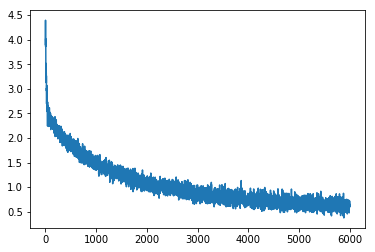

In [62]:
plt.plot(loss_history)

In [63]:
Y_pred = model.predict(X_test)

In [64]:
y_pred = np.argmax(Y_pred, axis=1)
y_test = np.argmax(Y_test, axis=1)

In [65]:
np.mean(y_pred == y_test)

0.8307

### Relu로 계산해 봄

In [66]:
r_model = FeedForwardNet()

In [67]:
r_model.add(Affine(784,50))
r_model.add(ReLu())
r_model.add(Affine(50,100))
r_model.add(ReLu())
r_model.add(Affine(100,10))
r_model.add(SoftmaxCrossEntropy())

In [68]:
r_loss_history = r_model.fit(X_train, Y_train, 
                         batch_size=100, iterator=600*10, 
                         learning_rate=0.01)

[학습 1] Loss: 3.55438301394816
[학습 2] Loss: 2.3449595212331245
[학습 3] Loss: 2.354612770844154
[학습 4] Loss: 2.378620517655891
[학습 5] Loss: 2.4192664354520685
[학습 6] Loss: 2.3553126320291464
[학습 7] Loss: 2.3494799630875285
[학습 8] Loss: 2.3745129264783604
[학습 9] Loss: 2.343025726400335
[학습 10] Loss: 2.465978315437137
[학습 11] Loss: 2.2938957890521707
[학습 12] Loss: 2.434884500153582
[학습 13] Loss: 2.409581146279302
[학습 14] Loss: 2.294174701696921
[학습 15] Loss: 2.422138267900832
[학습 16] Loss: 2.3806193705070977
[학습 17] Loss: 2.368661158278536
[학습 18] Loss: 2.3075513018075844
[학습 19] Loss: 2.403851166792476
[학습 20] Loss: 2.4168053773008267
[학습 21] Loss: 2.3820519110764513
[학습 22] Loss: 2.3103126340681555
[학습 23] Loss: 2.321474213940663
[학습 24] Loss: 2.4032230290177763
[학습 25] Loss: 2.4158112493166213
[학습 26] Loss: 2.3634117793762437
[학습 27] Loss: 2.339808896342316
[학습 28] Loss: 2.3826565162137014
[학습 29] Loss: 2.3640768807626658
[학습 30] Loss: 2.3332706249051443
[학습 31] Loss: 2.370536704940126
[

[학습 275] Loss: 2.289611480781365
[학습 276] Loss: 2.3107840074328765
[학습 277] Loss: 2.348729607207243
[학습 278] Loss: 2.3262990121377514
[학습 279] Loss: 2.3250007279479314
[학습 280] Loss: 2.3082433338321167
[학습 281] Loss: 2.317772292525562
[학습 282] Loss: 2.3386270515499272
[학습 283] Loss: 2.3163107729697985
[학습 284] Loss: 2.312664115416446
[학습 285] Loss: 2.3314944795457797
[학습 286] Loss: 2.340551696257283
[학습 287] Loss: 2.3473344399939613
[학습 288] Loss: 2.317692211256698
[학습 289] Loss: 2.3442201298045955
[학습 290] Loss: 2.3475690877182736
[학습 291] Loss: 2.3054871542483117
[학습 292] Loss: 2.3310651228936545
[학습 293] Loss: 2.3795306331785446
[학습 294] Loss: 2.2978783203339703
[학습 295] Loss: 2.3298195925159546
[학습 296] Loss: 2.3288044737277005
[학습 297] Loss: 2.3247045331730916
[학습 298] Loss: 2.363466924426602
[학습 299] Loss: 2.3828959817598547
[학습 300] Loss: 2.39079267977641
[학습 301] Loss: 2.411051440476794
[학습 302] Loss: 2.3258906769443315
[학습 303] Loss: 2.3269900061590705
[학습 304] Loss: 2.3256113

[학습 520] Loss: 2.342505433260484
[학습 521] Loss: 2.348145768497439
[학습 522] Loss: 2.328370713447239
[학습 523] Loss: 2.3001282563017744
[학습 524] Loss: 2.3408373590620655
[학습 525] Loss: 2.270036050782573
[학습 526] Loss: 2.3420089161233935
[학습 527] Loss: 2.3673490136779365
[학습 528] Loss: 2.3373142551772377
[학습 529] Loss: 2.3063989014285555
[학습 530] Loss: 2.3198489404729337
[학습 531] Loss: 2.355629343958903
[학습 532] Loss: 2.345576827541972
[학습 533] Loss: 2.341045803760245
[학습 534] Loss: 2.338553305886993
[학습 535] Loss: 2.2901530384518365
[학습 536] Loss: 2.3289985636470805
[학습 537] Loss: 2.3432130985597723
[학습 538] Loss: 2.273025114244171
[학습 539] Loss: 2.3327580251879803
[학습 540] Loss: 2.305656654699939
[학습 541] Loss: 2.322424525780093
[학습 542] Loss: 2.3278211259088666
[학습 543] Loss: 2.26933051016056
[학습 544] Loss: 2.287122405254347
[학습 545] Loss: 2.334325565836999
[학습 546] Loss: 2.31256053495733
[학습 547] Loss: 2.308157407984363
[학습 548] Loss: 2.3071340595382095
[학습 549] Loss: 2.287151556874388

[학습 799] Loss: 2.307763380630026
[학습 800] Loss: 2.3005411789060135
[학습 801] Loss: 2.301652322964632
[학습 802] Loss: 2.3215637545789813
[학습 803] Loss: 2.3338485389665338
[학습 804] Loss: 2.3150535401218097
[학습 805] Loss: 2.3284911881602053
[학습 806] Loss: 2.3022038677258028
[학습 807] Loss: 2.2985577756493605
[학습 808] Loss: 2.3199313666356627
[학습 809] Loss: 2.2869909086996527
[학습 810] Loss: 2.328458575987337
[학습 811] Loss: 2.3144902657822075
[학습 812] Loss: 2.3187270858179447
[학습 813] Loss: 2.3172988453396637
[학습 814] Loss: 2.2977174724834333
[학습 815] Loss: 2.300064886596788
[학습 816] Loss: 2.3119609959316283
[학습 817] Loss: 2.3174142628593386
[학습 818] Loss: 2.315619835948578
[학습 819] Loss: 2.300980118965468
[학습 820] Loss: 2.3095656782999527
[학습 821] Loss: 2.3295578885458155
[학습 822] Loss: 2.3073199087555394
[학습 823] Loss: 2.3446134742416307
[학습 824] Loss: 2.3136394477633213
[학습 825] Loss: 2.3294988245560986
[학습 826] Loss: 2.3182103372688467
[학습 827] Loss: 2.3110922697178005
[학습 828] Loss: 2.314

[학습 1043] Loss: 2.316124821770409
[학습 1044] Loss: 2.3288595027123566
[학습 1045] Loss: 2.307682717885342
[학습 1046] Loss: 2.319599992345762
[학습 1047] Loss: 2.32075115400335
[학습 1048] Loss: 2.3124669259007242
[학습 1049] Loss: 2.307650159908838
[학습 1050] Loss: 2.2854749743282228
[학습 1051] Loss: 2.3175869600067394
[학습 1052] Loss: 2.2982156046406805
[학습 1053] Loss: 2.3200051714574066
[학습 1054] Loss: 2.29894341004225
[학습 1055] Loss: 2.3138360981609303
[학습 1056] Loss: 2.3221822024157905
[학습 1057] Loss: 2.322511595973954
[학습 1058] Loss: 2.301557989003907
[학습 1059] Loss: 2.31564835311828
[학습 1060] Loss: 2.3109667739112854
[학습 1061] Loss: 2.330912281468932
[학습 1062] Loss: 2.3266896114909805
[학습 1063] Loss: 2.315627027261834
[학습 1064] Loss: 2.300371187267946
[학습 1065] Loss: 2.3150584809327994
[학습 1066] Loss: 2.323177934041405
[학습 1067] Loss: 2.321432542390053
[학습 1068] Loss: 2.3120487351913046
[학습 1069] Loss: 2.2788925114986527
[학습 1070] Loss: 2.342765774528542
[학습 1071] Loss: 2.3027970987078152
[학습

[학습 1307] Loss: 2.3063116832573467
[학습 1308] Loss: 2.3066614957899976
[학습 1309] Loss: 2.2934235700444443
[학습 1310] Loss: 2.299951837843518
[학습 1311] Loss: 2.330881305970837
[학습 1312] Loss: 2.300551686779785
[학습 1313] Loss: 2.3007213026365934
[학습 1314] Loss: 2.30821959294933
[학습 1315] Loss: 2.3157397236372805
[학습 1316] Loss: 2.3015511293017186
[학습 1317] Loss: 2.322217337866647
[학습 1318] Loss: 2.305667285107644
[학습 1319] Loss: 2.2967689628983057
[학습 1320] Loss: 2.3256580653275836
[학습 1321] Loss: 2.3059310679712834
[학습 1322] Loss: 2.296992601761242
[학습 1323] Loss: 2.3036272282091255
[학습 1324] Loss: 2.2953385942227893
[학습 1325] Loss: 2.310851170499587
[학습 1326] Loss: 2.3081249713104515
[학습 1327] Loss: 2.308472210807165
[학습 1328] Loss: 2.3152912261890104
[학습 1329] Loss: 2.303486113818065
[학습 1330] Loss: 2.288587521095607
[학습 1331] Loss: 2.3089020360682757
[학습 1332] Loss: 2.2978709155344643
[학습 1333] Loss: 2.306674069781659
[학습 1334] Loss: 2.315271187629533
[학습 1335] Loss: 2.2954137239669867

[학습 1559] Loss: 2.3138397204013494
[학습 1560] Loss: 2.3054729421091924
[학습 1561] Loss: 2.313246087117944
[학습 1562] Loss: 2.303037888401909
[학습 1563] Loss: 2.3016618455549063
[학습 1564] Loss: 2.28706219666918
[학습 1565] Loss: 2.305738634416711
[학습 1566] Loss: 2.3203746584214375
[학습 1567] Loss: 2.3208467090685865
[학습 1568] Loss: 2.298499157730565
[학습 1569] Loss: 2.3033056586238483
[학습 1570] Loss: 2.295209140366314
[학습 1571] Loss: 2.3099429295425966
[학습 1572] Loss: 2.2982782444989263
[학습 1573] Loss: 2.315007353372254
[학습 1574] Loss: 2.3086145395917947
[학습 1575] Loss: 2.3007975061477794
[학습 1576] Loss: 2.3133371561616833
[학습 1577] Loss: 2.3157667464294387
[학습 1578] Loss: 2.3002790245788445
[학습 1579] Loss: 2.306264557753628
[학습 1580] Loss: 2.293977965412087
[학습 1581] Loss: 2.2967659190142915
[학습 1582] Loss: 2.3046010427341086
[학습 1583] Loss: 2.290532989893382
[학습 1584] Loss: 2.3049779099409657
[학습 1585] Loss: 2.2972454014757724
[학습 1586] Loss: 2.3086666426104134
[학습 1587] Loss: 2.3225646161316

[학습 1814] Loss: 2.3042336819789027
[학습 1815] Loss: 2.30586312651641
[학습 1816] Loss: 2.3140698602222622
[학습 1817] Loss: 2.2966833181075588
[학습 1818] Loss: 2.298307600458697
[학습 1819] Loss: 2.291391148320152
[학습 1820] Loss: 2.306394164798587
[학습 1821] Loss: 2.292345290543134
[학습 1822] Loss: 2.3048194241299185
[학습 1823] Loss: 2.3125078461303077
[학습 1824] Loss: 2.3221885891855187
[학습 1825] Loss: 2.293617368301217
[학습 1826] Loss: 2.310728996201034
[학습 1827] Loss: 2.3010008174916385
[학습 1828] Loss: 2.292535362543246
[학습 1829] Loss: 2.296891229198788
[학습 1830] Loss: 2.3022260188153907
[학습 1831] Loss: 2.3188890119523613
[학습 1832] Loss: 2.297302616549417
[학습 1833] Loss: 2.31107085943132
[학습 1834] Loss: 2.3059051609831855
[학습 1835] Loss: 2.295382398967577
[학습 1836] Loss: 2.2957972767147408
[학습 1837] Loss: 2.295388235666261
[학습 1838] Loss: 2.3032386923646566
[학습 1839] Loss: 2.309455821184869
[학습 1840] Loss: 2.3051446020734256
[학습 1841] Loss: 2.2983680046039723
[학습 1842] Loss: 2.2866150579494233
[

[학습 2056] Loss: 2.303529106082058
[학습 2057] Loss: 2.303176316415655
[학습 2058] Loss: 2.316041898686754
[학습 2059] Loss: 2.3140182590101186
[학습 2060] Loss: 2.286949491295261
[학습 2061] Loss: 2.3110511109967358
[학습 2062] Loss: 2.309493663873041
[학습 2063] Loss: 2.3094022017521927
[학습 2064] Loss: 2.289805323417425
[학습 2065] Loss: 2.288105576515291
[학습 2066] Loss: 2.2971940052407853
[학습 2067] Loss: 2.2964658721813622
[학습 2068] Loss: 2.2969512466026396
[학습 2069] Loss: 2.3080848811388472
[학습 2070] Loss: 2.294038654951022
[학습 2071] Loss: 2.313142879358656
[학습 2072] Loss: 2.3015945605906767
[학습 2073] Loss: 2.3109213209757202
[학습 2074] Loss: 2.3102948628788353
[학습 2075] Loss: 2.309916175381112
[학습 2076] Loss: 2.3050022265721726
[학습 2077] Loss: 2.3033853999604674
[학습 2078] Loss: 2.3100309560082835
[학습 2079] Loss: 2.3059125915638052
[학습 2080] Loss: 2.2987461375713405
[학습 2081] Loss: 2.3023516785613527
[학습 2082] Loss: 2.2998698814346366
[학습 2083] Loss: 2.3154851705634756
[학습 2084] Loss: 2.301206971415

[학습 2309] Loss: 2.3068901406340405
[학습 2310] Loss: 2.294564408086897
[학습 2311] Loss: 2.298051837225368
[학습 2312] Loss: 2.3083646690347686
[학습 2313] Loss: 2.297994578073528
[학습 2314] Loss: 2.3143618327598308
[학습 2315] Loss: 2.3005948233706883
[학습 2316] Loss: 2.3074729756527983
[학습 2317] Loss: 2.306055589742138
[학습 2318] Loss: 2.2996058737001768
[학습 2319] Loss: 2.302244188936283
[학습 2320] Loss: 2.2907370699675162
[학습 2321] Loss: 2.297128890836327
[학습 2322] Loss: 2.2851764249462603
[학습 2323] Loss: 2.3024858184183934
[학습 2324] Loss: 2.3121578858018084
[학습 2325] Loss: 2.3028328203770148
[학습 2326] Loss: 2.3103592307214704
[학습 2327] Loss: 2.2935842249906346
[학습 2328] Loss: 2.3067311727664945
[학습 2329] Loss: 2.301048549230897
[학습 2330] Loss: 2.302943567170256
[학습 2331] Loss: 2.308662434368573
[학습 2332] Loss: 2.2982106346816455
[학습 2333] Loss: 2.301916499524566
[학습 2334] Loss: 2.2867057552354684
[학습 2335] Loss: 2.301104992451383
[학습 2336] Loss: 2.305573132541492
[학습 2337] Loss: 2.31123090501909

[학습 2561] Loss: 2.308341600142751
[학습 2562] Loss: 2.297412465355717
[학습 2563] Loss: 2.3014938820209467
[학습 2564] Loss: 2.2915535603664576
[학습 2565] Loss: 2.3029168907029067
[학습 2566] Loss: 2.280364433565355
[학습 2567] Loss: 2.2897025308690475
[학습 2568] Loss: 2.3008419670639517
[학습 2569] Loss: 2.3193613820672443
[학습 2570] Loss: 2.2999596909965145
[학습 2571] Loss: 2.305030636113703
[학습 2572] Loss: 2.3035003377738184
[학습 2573] Loss: 2.3017974059925677
[학습 2574] Loss: 2.3110516167259267
[학습 2575] Loss: 2.3072512768392
[학습 2576] Loss: 2.299983324493935
[학습 2577] Loss: 2.3060694882041104
[학습 2578] Loss: 2.3042704190837004
[학습 2579] Loss: 2.2906860086804515
[학습 2580] Loss: 2.3079460296467897
[학습 2581] Loss: 2.304001498982936
[학습 2582] Loss: 2.304274384147982
[학습 2583] Loss: 2.2936249303418
[학습 2584] Loss: 2.2997295362733423
[학습 2585] Loss: 2.2851854375343583
[학습 2586] Loss: 2.308223598516665
[학습 2587] Loss: 2.288318854769832
[학습 2588] Loss: 2.2939968290164785
[학습 2589] Loss: 2.2944945824503917


[학습 2803] Loss: 2.307836187240875
[학습 2804] Loss: 2.3074591309062913
[학습 2805] Loss: 2.3081759812733975
[학습 2806] Loss: 2.3047014751430885
[학습 2807] Loss: 2.2984144292468742
[학습 2808] Loss: 2.3022661688332557
[학습 2809] Loss: 2.304197685138167
[학습 2810] Loss: 2.3025018954773886
[학습 2811] Loss: 2.308195179285236
[학습 2812] Loss: 2.3051674900356516
[학습 2813] Loss: 2.294626628929347
[학습 2814] Loss: 2.30534958133827
[학습 2815] Loss: 2.292951295554744
[학습 2816] Loss: 2.303671294087927
[학습 2817] Loss: 2.3039155080725973
[학습 2818] Loss: 2.2947202000775144
[학습 2819] Loss: 2.2937515575816154
[학습 2820] Loss: 2.306758564045648
[학습 2821] Loss: 2.2882407176986685
[학습 2822] Loss: 2.3047357725640643
[학습 2823] Loss: 2.2958317550407656
[학습 2824] Loss: 2.2998376299714534
[학습 2825] Loss: 2.3088785530722062
[학습 2826] Loss: 2.303506407969485
[학습 2827] Loss: 2.303994633516636
[학습 2828] Loss: 2.2989217217621665
[학습 2829] Loss: 2.2993716170848884
[학습 2830] Loss: 2.3040375678491305
[학습 2831] Loss: 2.3057694930262

[학습 3044] Loss: 2.2925334110694986
[학습 3045] Loss: 2.3006354037549817
[학습 3046] Loss: 2.300597358923319
[학습 3047] Loss: 2.3036704197177666
[학습 3048] Loss: 2.287918786777628
[학습 3049] Loss: 2.3045532062121787
[학습 3050] Loss: 2.3012715303747022
[학습 3051] Loss: 2.3096058908906194
[학습 3052] Loss: 2.2959010311742505
[학습 3053] Loss: 2.2986081366397766
[학습 3054] Loss: 2.3046782825223318
[학습 3055] Loss: 2.3098501266581226
[학습 3056] Loss: 2.298684026593234
[학습 3057] Loss: 2.297174969478417
[학습 3058] Loss: 2.2980353885326106
[학습 3059] Loss: 2.304582974635116
[학습 3060] Loss: 2.299994911015726
[학습 3061] Loss: 2.2988527654327062
[학습 3062] Loss: 2.305590176356273
[학습 3063] Loss: 2.3022216956528037
[학습 3064] Loss: 2.300899970956976
[학습 3065] Loss: 2.3055463388831385
[학습 3066] Loss: 2.2928478375624817
[학습 3067] Loss: 2.2972471482861163
[학습 3068] Loss: 2.2944095556085817
[학습 3069] Loss: 2.2961764732953083
[학습 3070] Loss: 2.2999442659473353
[학습 3071] Loss: 2.3002429355847145
[학습 3072] Loss: 2.3133968294

[학습 3291] Loss: 2.2987025059562733
[학습 3292] Loss: 2.3010601968179714
[학습 3293] Loss: 2.2931969129294107
[학습 3294] Loss: 2.30800265530085
[학습 3295] Loss: 2.3011228729324715
[학습 3296] Loss: 2.2937879878335155
[학습 3297] Loss: 2.3093687821533506
[학습 3298] Loss: 2.2929399394162777
[학습 3299] Loss: 2.3122857256680414
[학습 3300] Loss: 2.3031486774531382
[학습 3301] Loss: 2.2981793432261055
[학습 3302] Loss: 2.3031307366245954
[학습 3303] Loss: 2.295373132566932
[학습 3304] Loss: 2.3000692134061715
[학습 3305] Loss: 2.3069175216812603
[학습 3306] Loss: 2.2980630969540856
[학습 3307] Loss: 2.300529718388988
[학습 3308] Loss: 2.2985152352997047
[학습 3309] Loss: 2.3048048765864513
[학습 3310] Loss: 2.3067017934985254
[학습 3311] Loss: 2.304057442437796
[학습 3312] Loss: 2.308839964656663
[학습 3313] Loss: 2.3004927685203107
[학습 3314] Loss: 2.303473185437769
[학습 3315] Loss: 2.2990682536221896
[학습 3316] Loss: 2.3132006508689473
[학습 3317] Loss: 2.3065823732390727
[학습 3318] Loss: 2.298867604837649
[학습 3319] Loss: 2.2988532744

[학습 3537] Loss: 2.3059280336777146
[학습 3538] Loss: 2.3071853607595636
[학습 3539] Loss: 2.297192487703991
[학습 3540] Loss: 2.299806714756254
[학습 3541] Loss: 2.3064085537693733
[학습 3542] Loss: 2.2916407400670185
[학습 3543] Loss: 2.3042677195037666
[학습 3544] Loss: 2.287414598832795
[학습 3545] Loss: 2.2943483085738796
[학습 3546] Loss: 2.307444676244304
[학습 3547] Loss: 2.3075001998138767
[학습 3548] Loss: 2.303543500868667
[학습 3549] Loss: 2.3022327224143737
[학습 3550] Loss: 2.304159271654058
[학습 3551] Loss: 2.301445183949748
[학습 3552] Loss: 2.302846868020034
[학습 3553] Loss: 2.3118763092148726
[학습 3554] Loss: 2.2982360060351548
[학습 3555] Loss: 2.304364994752149
[학습 3556] Loss: 2.305476213151914
[학습 3557] Loss: 2.3019474496389534
[학습 3558] Loss: 2.2944092660931017
[학습 3559] Loss: 2.301635489533682
[학습 3560] Loss: 2.2928912207668124
[학습 3561] Loss: 2.2986887425143654
[학습 3562] Loss: 2.2972429946396384
[학습 3563] Loss: 2.3062287880436307
[학습 3564] Loss: 2.2984058175610214
[학습 3565] Loss: 2.3019137430235

[학습 3779] Loss: 2.2928460400604176
[학습 3780] Loss: 2.296495864802331
[학습 3781] Loss: 2.3109945501774543
[학습 3782] Loss: 2.298853962821072
[학습 3783] Loss: 2.3067448518408464
[학습 3784] Loss: 2.303805200843696
[학습 3785] Loss: 2.2937544314925677
[학습 3786] Loss: 2.3014313283198184
[학습 3787] Loss: 2.307712505980356
[학습 3788] Loss: 2.301938587758374
[학습 3789] Loss: 2.3083257853064705
[학습 3790] Loss: 2.2912500439073065
[학습 3791] Loss: 2.3062079384583836
[학습 3792] Loss: 2.3074957091327035
[학습 3793] Loss: 2.308691272375565
[학습 3794] Loss: 2.3050816104551832
[학습 3795] Loss: 2.2909375297794004
[학습 3796] Loss: 2.300886647456721
[학습 3797] Loss: 2.291991709340163
[학습 3798] Loss: 2.3004297579155977
[학습 3799] Loss: 2.3037759421786768
[학습 3800] Loss: 2.293588500844541
[학습 3801] Loss: 2.300072328835619
[학습 3802] Loss: 2.3144958484713523
[학습 3803] Loss: 2.3043721142417968
[학습 3804] Loss: 2.30442903358628
[학습 3805] Loss: 2.3059694560715673
[학습 3806] Loss: 2.300700607257868
[학습 3807] Loss: 2.298370477813643

[학습 4024] Loss: 2.301270240043157
[학습 4025] Loss: 2.300699047404198
[학습 4026] Loss: 2.3146852797099084
[학습 4027] Loss: 2.3007680569130984
[학습 4028] Loss: 2.2935259692262893
[학습 4029] Loss: 2.2981369967895744
[학습 4030] Loss: 2.2981269336288443
[학습 4031] Loss: 2.3009871629524388
[학습 4032] Loss: 2.304538948506891
[학습 4033] Loss: 2.2920475790091537
[학습 4034] Loss: 2.2954134038390768
[학습 4035] Loss: 2.304227108307482
[학습 4036] Loss: 2.285381824537188
[학습 4037] Loss: 2.302817884196101
[학습 4038] Loss: 2.2935083520218775
[학습 4039] Loss: 2.304776051242509
[학습 4040] Loss: 2.310257754264099
[학습 4041] Loss: 2.309528564601307
[학습 4042] Loss: 2.2997471460793797
[학습 4043] Loss: 2.304709927006252
[학습 4044] Loss: 2.3062887485586625
[학습 4045] Loss: 2.2974920654068756
[학습 4046] Loss: 2.2994666486172552
[학습 4047] Loss: 2.299280533377169
[학습 4048] Loss: 2.308411036075366
[학습 4049] Loss: 2.3048039949493
[학습 4050] Loss: 2.2978439786598193
[학습 4051] Loss: 2.306355225250123
[학습 4052] Loss: 2.296765163909924
[학

[학습 4269] Loss: 2.293405160552553
[학습 4270] Loss: 2.306722794547422
[학습 4271] Loss: 2.294284233513403
[학습 4272] Loss: 2.301166870623122
[학습 4273] Loss: 2.2954990373160644
[학습 4274] Loss: 2.3081228675789993
[학습 4275] Loss: 2.297584565158408
[학습 4276] Loss: 2.2969574903767462
[학습 4277] Loss: 2.2973351090878147
[학습 4278] Loss: 2.3052466508888143
[학습 4279] Loss: 2.300700830287964
[학습 4280] Loss: 2.3060790371470885
[학습 4281] Loss: 2.3011734647056854
[학습 4282] Loss: 2.2967190786072043
[학습 4283] Loss: 2.308000076743093
[학습 4284] Loss: 2.3046671059293056
[학습 4285] Loss: 2.303132605228651
[학습 4286] Loss: 2.2948257474047895
[학습 4287] Loss: 2.3016212922090697
[학습 4288] Loss: 2.301953363565497
[학습 4289] Loss: 2.303326436301845
[학습 4290] Loss: 2.2894864063431366
[학습 4291] Loss: 2.302098886584631
[학습 4292] Loss: 2.2999422276406842
[학습 4293] Loss: 2.304208745024549
[학습 4294] Loss: 2.2931205676918784
[학습 4295] Loss: 2.301250610879288
[학습 4296] Loss: 2.3078353389762465
[학습 4297] Loss: 2.300412325218209

[학습 4515] Loss: 2.2949637392725193
[학습 4516] Loss: 2.3007036622355783
[학습 4517] Loss: 2.292365803786332
[학습 4518] Loss: 2.3028846379882695
[학습 4519] Loss: 2.300192227881973
[학습 4520] Loss: 2.30361643444417
[학습 4521] Loss: 2.307777331318494
[학습 4522] Loss: 2.2886736524267954
[학습 4523] Loss: 2.306755815288176
[학습 4524] Loss: 2.3031618811133088
[학습 4525] Loss: 2.3038652743869075
[학습 4526] Loss: 2.301783086232943
[학습 4527] Loss: 2.3000571395392178
[학습 4528] Loss: 2.300647321095499
[학습 4529] Loss: 2.3033425119052633
[학습 4530] Loss: 2.3038283555314707
[학습 4531] Loss: 2.294891076758966
[학습 4532] Loss: 2.298462109210037
[학습 4533] Loss: 2.304751070587693
[학습 4534] Loss: 2.3028352124203217
[학습 4535] Loss: 2.3023833961152955
[학습 4536] Loss: 2.29401037057677
[학습 4537] Loss: 2.3065092667305147
[학습 4538] Loss: 2.301218162590235
[학습 4539] Loss: 2.2997881609858446
[학습 4540] Loss: 2.298677777334063
[학습 4541] Loss: 2.31032798427515
[학습 4542] Loss: 2.3009521104249804
[학습 4543] Loss: 2.3048984623231634
[학

[학습 4755] Loss: 2.291873436008501
[학습 4756] Loss: 2.3001906354702437
[학습 4757] Loss: 2.300677565535636
[학습 4758] Loss: 2.301528136981561
[학습 4759] Loss: 2.29817844610538
[학습 4760] Loss: 2.278383655674686
[학습 4761] Loss: 2.3052372278220092
[학습 4762] Loss: 2.2961194546750954
[학습 4763] Loss: 2.2948141025988553
[학습 4764] Loss: 2.300198749385653
[학습 4765] Loss: 2.300482984217629
[학습 4766] Loss: 2.305127025455447
[학습 4767] Loss: 2.3038974632348057
[학습 4768] Loss: 2.2983983438357707
[학습 4769] Loss: 2.304878953447759
[학습 4770] Loss: 2.3072062239436897
[학습 4771] Loss: 2.290965557761154
[학습 4772] Loss: 2.3032383387037965
[학습 4773] Loss: 2.301634052960517
[학습 4774] Loss: 2.302256280498935
[학습 4775] Loss: 2.297837009030993
[학습 4776] Loss: 2.2979995841966905
[학습 4777] Loss: 2.3138068814352573
[학습 4778] Loss: 2.2990754012357204
[학습 4779] Loss: 2.306079194448791
[학습 4780] Loss: 2.2979869595431306
[학습 4781] Loss: 2.296632465535148
[학습 4782] Loss: 2.3039409645848665
[학습 4783] Loss: 2.2949441283686878
[

[학습 5003] Loss: 2.287737257041806
[학습 5004] Loss: 2.2979717309026517
[학습 5005] Loss: 2.3000090279579752
[학습 5006] Loss: 2.2959902959379948
[학습 5007] Loss: 2.30269318000235
[학습 5008] Loss: 2.2984218142654624
[학습 5009] Loss: 2.3030544990595745
[학습 5010] Loss: 2.2956687463106693
[학습 5011] Loss: 2.291512917144502
[학습 5012] Loss: 2.299438233137846
[학습 5013] Loss: 2.296872122672937
[학습 5014] Loss: 2.2978332871375597
[학습 5015] Loss: 2.299939328074097
[학습 5016] Loss: 2.296145052638977
[학습 5017] Loss: 2.302720473673129
[학습 5018] Loss: 2.288306069875421
[학습 5019] Loss: 2.2987774428262795
[학습 5020] Loss: 2.3078156436712023
[학습 5021] Loss: 2.308832144596679
[학습 5022] Loss: 2.3005825394347204
[학습 5023] Loss: 2.3031676144274154
[학습 5024] Loss: 2.3019814815640767
[학습 5025] Loss: 2.3014496038432135
[학습 5026] Loss: 2.2998845891703037
[학습 5027] Loss: 2.300382859730287
[학습 5028] Loss: 2.300965268829766
[학습 5029] Loss: 2.2979447862985465
[학습 5030] Loss: 2.2915250055660206
[학습 5031] Loss: 2.304813342310503

[학습 5251] Loss: 2.299822970527415
[학습 5252] Loss: 2.3024526346775755
[학습 5253] Loss: 2.3126362347536573
[학습 5254] Loss: 2.3068383596800937
[학습 5255] Loss: 2.2935480020983743
[학습 5256] Loss: 2.2988951248089973
[학습 5257] Loss: 2.3006335057776295
[학습 5258] Loss: 2.303720393451491
[학습 5259] Loss: 2.3009262836325264
[학습 5260] Loss: 2.290357380086773
[학습 5261] Loss: 2.306459594073763
[학습 5262] Loss: 2.2935960876991692
[학습 5263] Loss: 2.300349928651088
[학습 5264] Loss: 2.301051904524535
[학습 5265] Loss: 2.2877512423256188
[학습 5266] Loss: 2.3040561933069506
[학습 5267] Loss: 2.288299404454624
[학습 5268] Loss: 2.2982004374128158
[학습 5269] Loss: 2.287374129214298
[학습 5270] Loss: 2.298520903897513
[학습 5271] Loss: 2.2908919512254466
[학습 5272] Loss: 2.3126597535829143
[학습 5273] Loss: 2.3063013614492704
[학습 5274] Loss: 2.303555848783793
[학습 5275] Loss: 2.312562410622223
[학습 5276] Loss: 2.302063664740871
[학습 5277] Loss: 2.3040485742468144
[학습 5278] Loss: 2.290507034171024
[학습 5279] Loss: 2.296198997820524

[학습 5497] Loss: 2.2973396033239526
[학습 5498] Loss: 2.2908410914230393
[학습 5499] Loss: 2.2944808053956898
[학습 5500] Loss: 2.2948839569483703
[학습 5501] Loss: 2.29623656242024
[학습 5502] Loss: 2.30419637805496
[학습 5503] Loss: 2.293849482196883
[학습 5504] Loss: 2.300767310084367
[학습 5505] Loss: 2.302354594332779
[학습 5506] Loss: 2.2989850810531416
[학습 5507] Loss: 2.3056603986079334
[학습 5508] Loss: 2.312655427810965
[학습 5509] Loss: 2.2926720676357486
[학습 5510] Loss: 2.3051080428126505
[학습 5511] Loss: 2.2943349819866596
[학습 5512] Loss: 2.2995618505432707
[학습 5513] Loss: 2.2994412566163267
[학습 5514] Loss: 2.299511181929524
[학습 5515] Loss: 2.3024904660670904
[학습 5516] Loss: 2.301750090108933
[학습 5517] Loss: 2.306497729442225
[학습 5518] Loss: 2.3062781144371
[학습 5519] Loss: 2.3036519891668648
[학습 5520] Loss: 2.3048123971977237
[학습 5521] Loss: 2.29169219944508
[학습 5522] Loss: 2.2992429568720762
[학습 5523] Loss: 2.302466276212052
[학습 5524] Loss: 2.303351263008524
[학습 5525] Loss: 2.3105777968918138
[학습

[학습 5743] Loss: 2.286472353609417
[학습 5744] Loss: 2.2993726038667144
[학습 5745] Loss: 2.304350220139022
[학습 5746] Loss: 2.30251305269357
[학습 5747] Loss: 2.288747219510755
[학습 5748] Loss: 2.3047252625972274
[학습 5749] Loss: 2.3069962762325513
[학습 5750] Loss: 2.292276854323061
[학습 5751] Loss: 2.302895152139792
[학습 5752] Loss: 2.2982222269961743
[학습 5753] Loss: 2.3079816518189697
[학습 5754] Loss: 2.297721524954356
[학습 5755] Loss: 2.3028500574840503
[학습 5756] Loss: 2.3006225944863545
[학습 5757] Loss: 2.2951716971066123
[학습 5758] Loss: 2.298997807253772
[학습 5759] Loss: 2.298122832917832
[학습 5760] Loss: 2.299484390129482
[학습 5761] Loss: 2.299650328890035
[학습 5762] Loss: 2.3076228954861286
[학습 5763] Loss: 2.306935034200825
[학습 5764] Loss: 2.302608527349603
[학습 5765] Loss: 2.2951839206069864
[학습 5766] Loss: 2.2975170776367047
[학습 5767] Loss: 2.3084768946401857
[학습 5768] Loss: 2.3080147053407174
[학습 5769] Loss: 2.29854207018693
[학습 5770] Loss: 2.2970601840276865
[학습 5771] Loss: 2.3025479630268317
[

[학습 5988] Loss: 2.292647447249151
[학습 5989] Loss: 2.3051483369187378
[학습 5990] Loss: 2.3052991471566857
[학습 5991] Loss: 2.3015909489515476
[학습 5992] Loss: 2.298184636353383
[학습 5993] Loss: 2.303613962724902
[학습 5994] Loss: 2.2985371122304583
[학습 5995] Loss: 2.3149999877238234
[학습 5996] Loss: 2.307140639432532
[학습 5997] Loss: 2.3032003097514018
[학습 5998] Loss: 2.294999147971897
[학습 5999] Loss: 2.302711280784905
[학습 6000] Loss: 2.3066635240455313


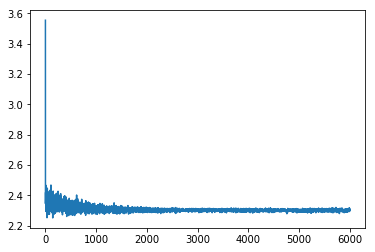

In [69]:
plt.plot(r_loss_history)

In [70]:
Y_pred = r_model.predict(X_test)

In [71]:
y_pred = np.argmax(Y_pred, axis=1)
y_test = np.argmax(Y_test, axis=1)

In [72]:
np.mean(y_pred == y_test)

0.1135

In [73]:
# relu가 simoid 성능이 좋은게 보통인데, 더 안 좋게 나왔으니까 이유가 무엇인지 찾아봐야 함. 뭔가 구현 내용에 문제가 있는 듯??

In [ ]:
# 활성화값을 개선하기 위해서 활성화함수를 바꾸는 것이 됨.

In [ ]:
# https://pypi.org/

# 딥러닝 라이브러리
tensorflow + keras